In [3]:
#Importlibraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


sns.set(style='whitegrid')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Set the path to your dataset
data_dir = '/content/drive/MyDrive/The IQ-OTHNCCD lung cancer dataset'

#Define the categories (classes)
categories = ['Normal cases', 'Bengin cases', 'Malignant cases']

# Image size expected by ResNet50 (224x224)
img_size = (224, 224)


In [6]:
# Initialize the ImageDataGenerator for data augmentation and normalization
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)


In [8]:
# Load images from the directory, split for training and validation
train_data = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_data = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 878 images belonging to 3 classes.
Found 219 images belonging to 3 classes.


In [9]:
#Load the ResNet50 model with pre-trained ImageNet weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(categories), activation='softmax')(x)



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [10]:
# model
model = Model(inputs=base_model.input, outputs=predictions)

#Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
#Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=60,  #
    steps_per_epoch=train_data.samples // train_data.batch_size,
    validation_steps=val_data.samples // val_data.batch_size
)

Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 296s 9s/step - accuracy: 0.4971 - loss: 1.2801 - val_accuracy: 0.5417 - val_loss: 1.0154
Epoch 2/60
 1/27 ━━━━━━━━━━━━━━━━━━━━ 2:11 5s/step - accuracy: 0.6875 - loss: 0.6338

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - accuracy: 0.6875 - loss: 0.6338 - val_accuracy: 0.7037 - val_loss: 1.1059
Epoch 3/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 195s 7s/step - accuracy: 0.6448 - loss: 0.8153 - val_accuracy: 0.6354 - val_loss: 1.0465
Epoch 4/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 247ms/step - accuracy: 0.7857 - loss: 0.6800 - val_accuracy: 0.5926 - val_loss: 1.4575
Epoch 5/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 187s 7s/step - accuracy: 0.6973 - loss: 0.7147 - val_accuracy: 0.5729 - val_loss: 0.9911
Epoch 6/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.6875 - loss: 0.8109 - val_accuracy: 0.6667 - val_loss: 1.0402
Epoch 7/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 189s 7s/step - accuracy: 0.7290 - loss: 0.6421 - val_accuracy: 0.5052 - val_loss: 0.9623
Epoch 8/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 154ms/step - accuracy: 0.7500 - loss: 0.6413 - val_accuracy: 0.4074 - val_loss: 1.1052
Epoch 9/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 194s 7s/step - accuracy: 0.7466 - loss: 0.6077 - val_accuracy: 0.5677 - val_loss: 

In [12]:
# Save the trained model
model.save('lung_cancer_resnet50.h5')

# Evaluate the model on validation set (Test Accuracy)
loss, test_accuracy = model.evaluate(val_data)
print(f'Validation (Test) Accuracy: {test_accuracy * 100:.2f}%')

#Get the training accuracy (final epoch)
train_accuracy = history.history['accuracy'][-1]
print(f'Train Accuracy: {train_accuracy * 100:.2f}%')

7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - accuracy: 0.6973 - loss: 0.8717
Validation (Test) Accuracy: 71.69%
Train Accuracy: 96.88%


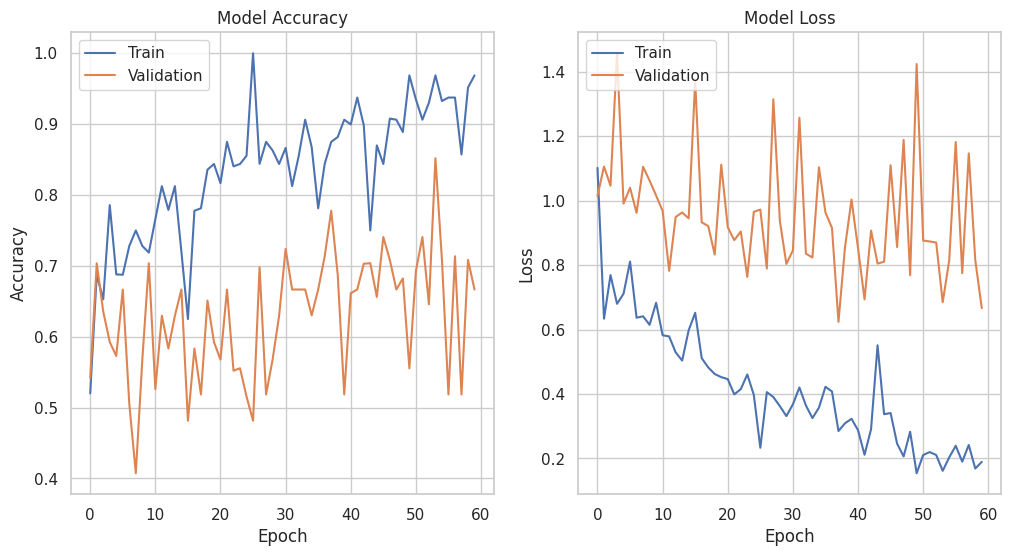

In [13]:
# Histograms

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [14]:
#predictions on validation data
val_data.reset()
predictions = model.predict(val_data)

# Convert predictions and true labels back from one-hot encoding
predicted_classes = np.argmax(predictions, axis=1)
true_classes = val_data.classes
class_labels = list(val_data.class_indices.keys())

7/7 ━━━━━━━━━━━━━━━━━━━━ 43s 6s/step


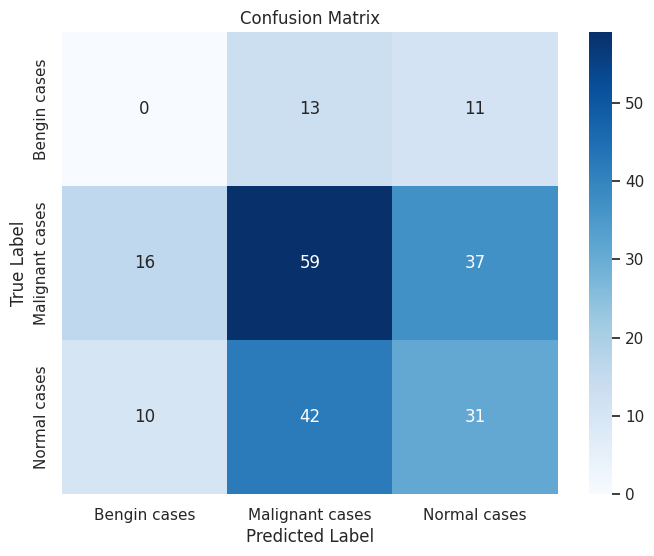

                 precision    recall  f1-score   support

   Bengin cases       0.00      0.00      0.00        24
Malignant cases       0.52      0.53      0.52       112
   Normal cases       0.39      0.37      0.38        83

       accuracy                           0.41       219
      macro avg       0.30      0.30      0.30       219
   weighted avg       0.41      0.41      0.41       219



In [15]:
# Confusion Matrix and Classification Report
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(classification_report(true_classes, predicted_classes, target_names=class_labels))


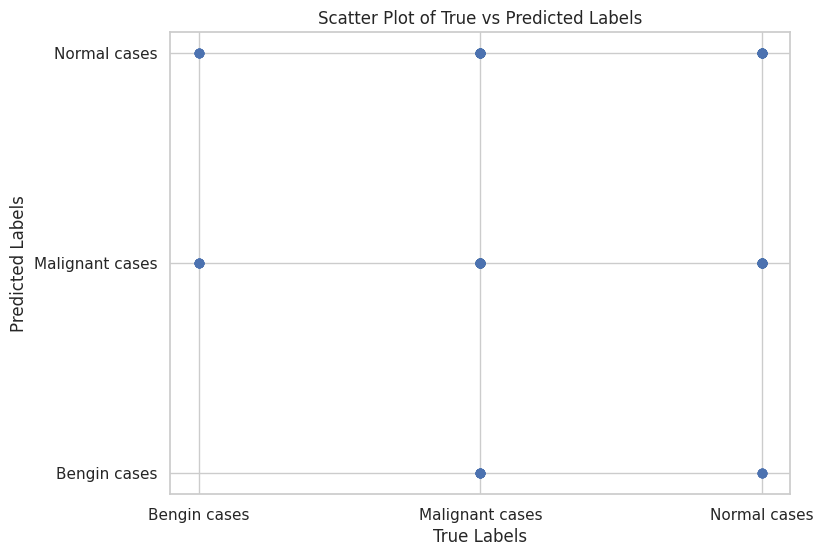

In [16]:
#Scatter Plot for the Predictions vs True Labels
plt.figure(figsize=(8, 6))
plt.scatter(true_classes, predicted_classes, alpha=0.5)
plt.title('Scatter Plot of True vs Predicted Labels')
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.xticks(np.arange(len(class_labels)), class_labels)
plt.yticks(np.arange(len(class_labels)), class_labels)
plt.grid(True)
plt.show()